<a href="https://colab.research.google.com/github/ahmadSultan-12/Embedded-Lab/blob/main/FireAndSmokeDetectionUsingTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required packages...

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2    
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt
import pickle

print("all packages imported successfully")

all packages imported successfully


In [ ]:
# Creates a Batch Data Object
def create_dataset_instance(data_address, image_size, batch_size,
                            rescale_images = 1, 
                            rotation_range = 0, 
                            width_range = 0,
                            height_range = 0,
                            do_horizontal_flip = False):
  
  data_generator = ImageDataGenerator(
      rescale = rescale_images,         # Data Normalization
      rotation_range = rotation_range,        # Data Augmentation 
      width_shift_range = width_range,
      height_shift_range = height_range,
      horizontal_flip = do_horizontal_flip   
  )  

  batch_data = data_generator.flow_from_directory(
    directory = data_address, # loading data from disk
    class_mode = 'binary',
    target_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb',
    shuffle = True 
    )
  return batch_data

print("Function created successfully.")

Function created successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive



Fire and Non-Fire Combined DataSet Details:
Found 5171 images belonging to 2 classes.

Green colour for Non-Fire Images
Red colour for Fire Images


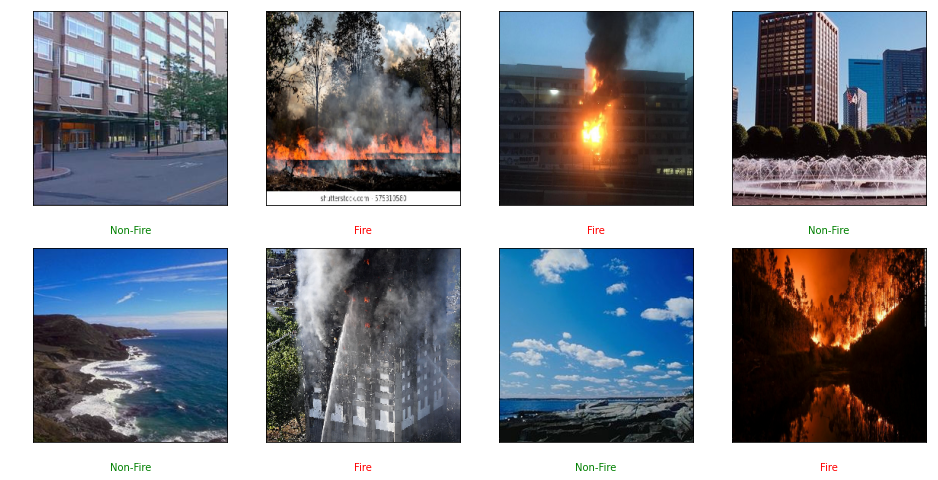

In [ ]:
## Step1: "Data Collection"

# Source Reference:    https://github.com/cair/Fire-Detection-Image-Dataset
#                      https://www.pyimagesearch.com/2019/11/18/fire-and-smoke-detection-with-keras-and-deep-learning/

# Visualizing Random Images from DataSet
data_address = '/content/drive/My Drive/dataset'
num_images = 8  # specify no.of images to visualize....
image_size = (256, 256)  # set resolution of image...

print("\nFire and Non-Fire Combined DataSet Details:")
generator = create_dataset_instance(data_address, # using the defined function 
                                   image_size, 
                                   num_images
                                   )

classes = ["Fire", "Non-Fire"]
class_color = ["red", "green"]
x, y = next(generator)
plt.figure(figsize=(2*num_images, num_images))
for i in range(num_images):
    ax = plt.subplot(num_images/4, 4, i + 1)
    ax.tick_params(axis='both', colors='white')
    plt.imshow(x[i].astype('uint8'))
    plt.xlabel(xlabel = classes[int(y[i])], color = class_color[int(y[i])])

print("\nGreen colour for Non-Fire Images")
print("Red colour for Fire Images")
plt.show()

In [ ]:
## Step2: "Split Original DataSet into train, val, test"
!pip install split_folders
import split_folders

train = 0.60
val = 0.20
test = 0.20

split_folders.ratio(
    '/content/drive/My Drive/dataset', # Input folder address
     output="/content/drive/My Drive/splitted_dataset_1", # output folder address
     ratio=(train, val, test)     # split ratio for (TRAIN, VAL, TEST)
     )     

In [ ]:
## Step3: "Data Preprocessing"

# Training Data...
train_data_address = '/content/drive/My Drive/splitted_dataset_1/train' 
train_batch_size = 64
image_target_size = (128, 128)
rescale = 1./255

print("\nTrain Dataset Details:")
train_data = create_dataset_instance( # using the defined function
    train_data_address, 
    image_target_size, 
    train_batch_size,
    rescale_images = rescale, #Data Normalization
    rotation_range = 20,   # Data Augmentation
    width_range = 0.25,
    height_range = 0.2,
    do_horizontal_flip = True
    )

num_train_batches = len(train_data)

# Validation Data....
val_data_address = '/content/drive/My Drive/splitted_dataset_1/val'
print("\nValidation Dataset Details:")
val_data = create_dataset_instance(  # using the defined function
    val_data_address,
    image_target_size, 
    train_batch_size,
    rescale_images = rescale, #Data Normalization
    )

# Test Data....
test_data_address = '/content/drive/My Drive/splitted_dataset_1/test'
print("\nTest Dataset Details:")
test_data = create_dataset_instance(  # using the defined function
    test_data_address,
    image_target_size, 
    train_batch_size,
    rescale_images = rescale, #Data Normalization
    )




Train Dataset Details:
Found 3101 images belonging to 2 classes.

Validation Dataset Details:
Found 1033 images belonging to 2 classes.

Test Dataset Details:
Found 1037 images belonging to 2 classes.


In [ ]:
## Step4: "CNN Model Building"

# Using Transfer Learning.....
mnet = MobileNetV2(include_top=False,        # remove top layer of MobileNet_V2
                   input_shape = (128, 128, 3),
                   pooling = 'avg',                # 4D Tensor to 2D Tensor
                   weights = 'imagenet')             # use pre-trained weights
mnet.summary()
def create_model():
    model = Sequential(
        [mnet,
        Dense(256, activation='relu'), # Add a Fully Connected layer....
        Dense(1, activation='sigmoid')  # Binary Classification
    ])

    model.layers[0].trainable = False # dont train the MobileNet_V2 portion...
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = create_model() # create a model instance...
model.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
________________

In [ ]:
## Step5: "CNN Model Training"


train_val_history = model.fit(
    x = train_data,
    epochs = 30,
    verbose = 1,
    validation_data = val_data,
    steps_per_epoch = num_train_batches,
    validation_freq = 1
)

# Save Training and Validation History in a Dictionary....
with open('/content/drive/My Drive/mobile_net_history_final5', 'wb') as f:
  pickle.dump(train_val_history.history, f)

# save model to disk for later use...
model.save("/content/drive/My Drive/mobile_net_final6.h5")


Epoch 1/30
48/49 [============================>.] - ETA: 1s - loss: 0.3323 - acc: 0.8541

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/49 [==============================] - 115s 2s/step - loss: 0.3286 - acc: 0.8555 - val_loss: 0.1842 - val_acc: 0.9167
Epoch 2/30
49/49 [==============================] - 111s 2s/step - loss: 0.1626 - acc: 0.9394 - val_loss: 0.1596 - val_acc: 0.9293
Epoch 3/30
49/49 [==============================] - 115s 2s/step - loss: 0.1508 - acc: 0.9436 - val_loss: 0.1436 - val_acc: 0.9322
Epoch 4/30
49/49 [==============================] - 113s 2s/step - loss: 0.1360 - acc: 0.9442 - val_loss: 0.1904 - val_acc: 0.9119
Epoch 5/30
49/49 [==============================] - 114s 2s/step - loss: 0.1145 - acc: 0.9616 - val_loss: 0.1305 - val_acc: 0.9477
Epoch 6/30
49/49 [==============================] - 113s 2s/step - loss: 0.1096 - acc: 0.9607 - val_loss: 0.1158 - val_acc: 0.9506
Epoch 7/30
49/49 [==============================] - 113s 2s/step - loss: 0.0949 - acc: 0.9649 - val_loss: 0.1203 - val_acc: 0.9468
Epoch 8/30
49/49 [==============================] - 110s 2s/step - loss: 0.0933 - acc: 0.9636 

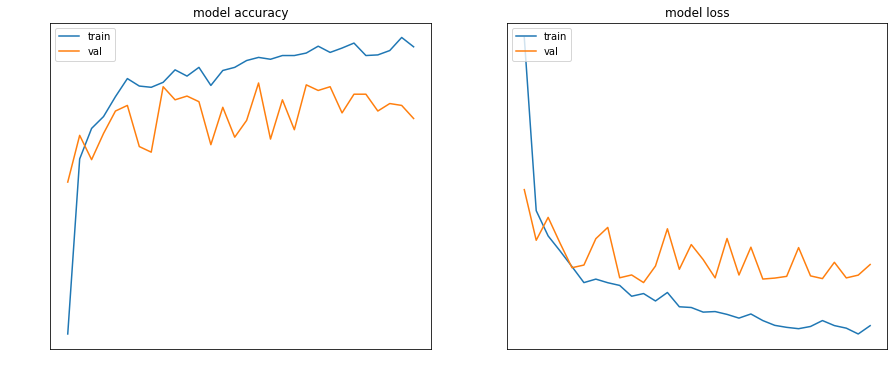

In [ ]:
## Step6:   "Plotting Training and Validation History"

with open('/content/drive/My Drive/mobile_net_history_final5', 'rb') as f:
    # load using pickle de-serializer
    history = pickle.load(f)

plt.figure(figsize=(15, 6))

# plot model accuracies...
ax = plt.subplot(1, 2, 1) 
ax.tick_params(axis='both', colors='white')
plt.plot(history["acc"])
plt.plot(history["val_acc"])
plt.title('model accuracy')
plt.ylabel("accuracy", color = 'white')
plt.xlabel("epoch", color = 'white')
plt.legend(['train', 'val'], loc = 'upper left')

# plot model losses...
ax = plt.subplot(1, 2, 2) # loss
ax.tick_params(axis='both', colors='white')
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title('model loss')
plt.ylabel("loss", color = 'white')
plt.xlabel("epoch", color = 'white')
plt.legend(['train', 'val'], loc = 'upper left')

plt.show()

In [ ]:
## Step7:   "Model Testing"

# load the trained model weights...
model = load_model("/content/drive/My Drive/mobile_net_final6.h5")  
test_results = model.evaluate(x = test_data,
               verbose=1
               )

print ("\nTest Loss = " + str(test_results[0]))
print ("Test Accuracy = " + str(test_results[1]))

17/17 [==============================] - 247s 15s/step - loss: 0.1408 - acc: 0.9479

Test Loss = 0.1408064067363739
Test Accuracy = 0.9479267001152039



DataSet Details:
Found 5171 images belonging to 2 classes.

Red colour shows WRONG PREDICTION
Green colour shows CORRECT PREDICTION


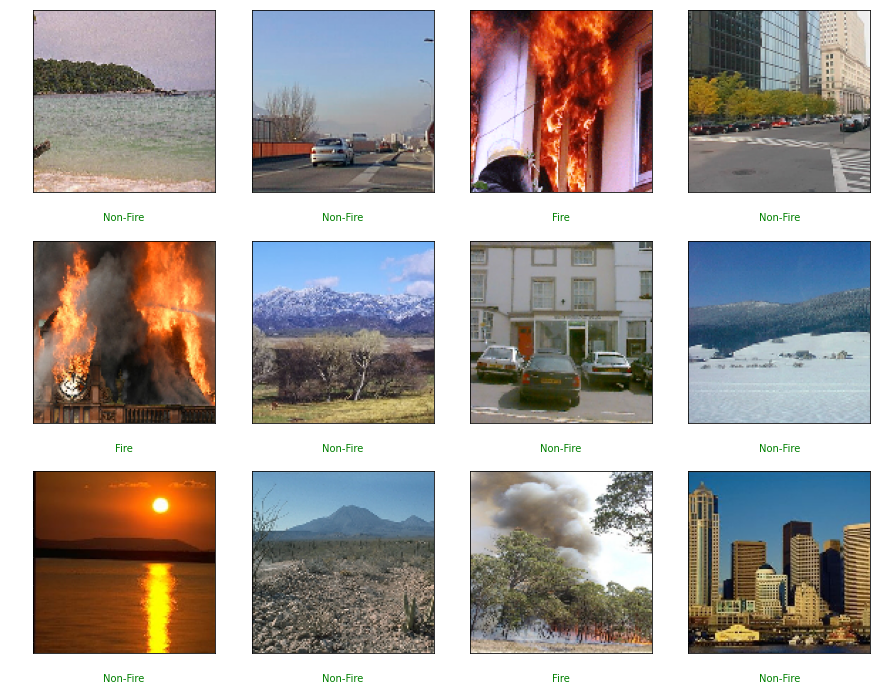

In [ ]:
## Step8:   "Making Predictions on Random Images from DataSet"

#model = load_model("/content/drive/My Drive/mobile_net_final6.h5")  
# Testing Random Images from DataSet
data_address = '/content/drive/My Drive/dataset'
num_images = 12 # specify no.of images to test at a time.... 
target_size = (128, 128)

print("\nDataSet Details:")
generator = create_dataset_instance(   #function call
    data_address,
    target_size,                                
    num_images
    )

labels = ["Fire", "Non-Fire"]
x, y = next(generator)
x = x/255.0
pred = model.predict(x)     # predictions...

plt.figure(figsize=(15, num_images))
for i in range(num_images):
    ax = plt.subplot(num_images/4, 4, i + 1)
    ax.tick_params(axis='both', colors='white')
    plt.imshow((x[i]*255).astype('uint8'))
    pred_y = 0 if pred[i] <= 0.5 else 1 
    # comparing predicted class with original data.... 
    colour = "green" if pred_y == y[i] else "red"   
    plt.xlabel(xlabel = labels[pred_y], color = colour)

print("\nRed colour shows WRONG PREDICTION")
print("Green colour shows CORRECT PREDICTION")

plt.show()
